# **Loan Repayment Prediction**

**A kernel to explore loan repayment prediction using machine learning**

*Komal Bakshi, 31st October 2021*

### Dataset used in this kernel:

[Home Credit](https://www.kaggle.com/c/home-credit-default-risk/overview)
 
 In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

#### **Contents:**
1. [Introduction](#introduction)
2. [Real World Considerations](#realworld)
3. [Performance Metric](#metric)
4. [Data Overview](#data)
5. [Exploratory Data Analysis](#explore)
6. [Data Preperation and Feature Engineering](#feature)
7. [Machine Learning models](#ml)
8. [Results and Summary](#results)
9. [References](#refer)

<div id="introduction">
    <h3>Introduction</h3>

An existential problem for loan providers today is to identify loan applicants who are more likely to repay the loan. This ensures lending institutions minimise losses and incur profits.

 Home Credit offers easy, simple and fast loans for a range of Home Appliances, Mobile Phones, Laptops, Two Wheeler's , and various personal needs. Home Credit has come up with a dataset to enable evaluation of the loan applicants who are capable of repaying a loan, given the applicant data, credit data from Credit Bureau, historical application data from Home Credit and other such attributes.
</div>

<div id=realworld>
<h3>Real World Considerations</h3>
</div>

*  Predicting the likelihood of an applicant repaying loan

Consider two applicants A, B whose probability of repaying loan are 0.6 and 0.9 respectively. In case the accepted threshold in machine learning models is considered to be 0.5; both the applicants are labeled as a positive outcome (‘Repaying loan’). But in reality applicant B is more likely to repay the loan as compared to applicant A. If we predict the probabilities we can set the threshold to higher values such as 0.8, 0.9 as per business requirements.
    
    
*  Mis-classification can prove costly 

This is binary classification problem (0- loan repayed, 1- defaulter), hence the cost of mis-classification can be high.

*  Interpretability is partially significant

As long as our model performs well on the test data, we don’t need to worry much about interpretability. This is more so because are problem is not set in a  medical context (where interpretability is significant- cancer detection). We can still give importance to some form of interpretability like feature significance.

<div id="metric">
<h3>Performance Metric</h3>
</div>

In this problem, the data is imbalanced. So we can’t use accuracy as a error metric. When data is imbalanced we can use Log loss, F1-score and AUC. Here we are sticking to AUC which can handle imbalanced datasets.

* **Area Under Curve (AUC)**

An ROC curve is the most commonly used way to visualize the performance of a binary classifier, and AUC is (arguably) the best way to summarize its performance in a single number.

* **Confusion Matrix (To get an overview of complete predictions)**
    
For more information, you can check out this video: [ROC and AUC Explained](https://youtu.be/OAl6eAyP-yo)

<div id="data"> </div>
<h3> Data Overview </h3>
For detailed information refer to: 

[Home Credit Data](https://www.kaggle.com/c/home-credit-default-risk/data)

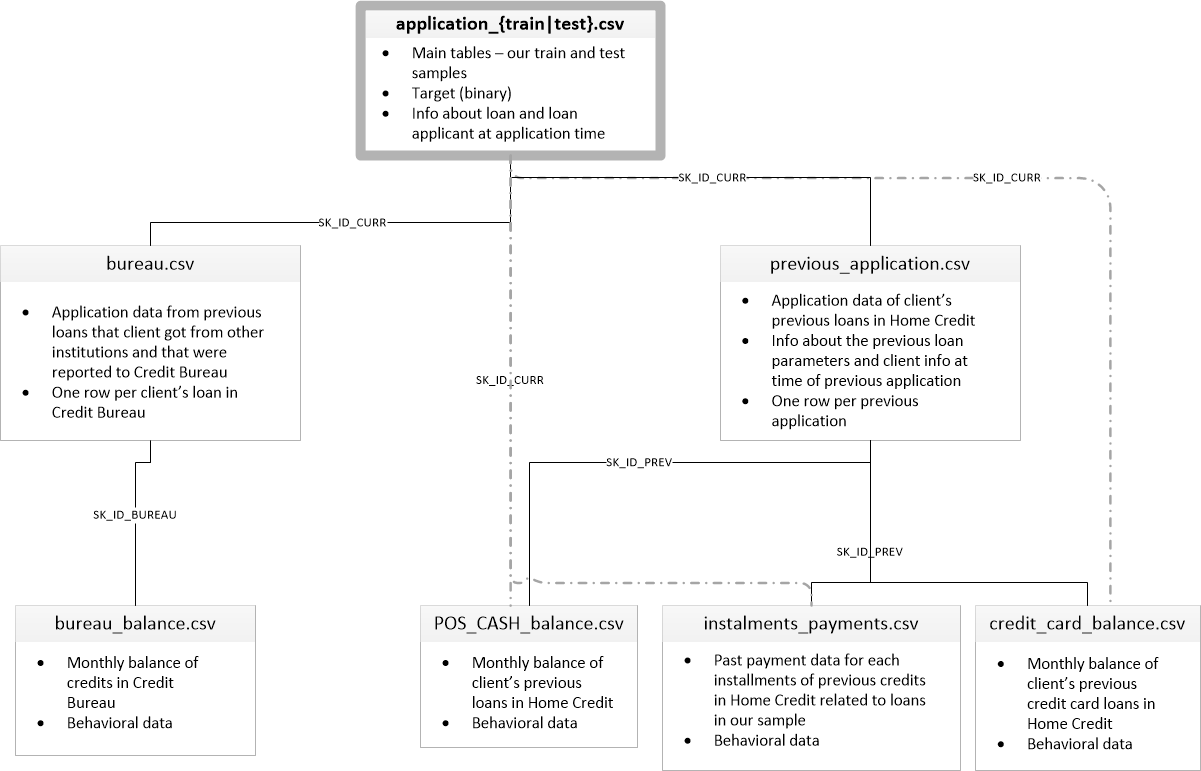


* Importing relevant libraries

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
import re
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline

<div id="explore">
    <h3>Exploratory Data Analysis</h3>
</div>

In [ ]:
print('Reading the data....', end='')
application = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('done!!!')
print('The shape of data:',application.shape)
print('First 5 rows of data:')
application.head()

1. This dataset consists of 307511 rows and 122 columns.
2. Each row has unique id ‘SK_ID_CURR’ and the output label is in the ‘TARGET’ column.
3. TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
4. The description of each column can be found in the file ‘HomeCredit_columns_description.csv’

* Identifying missing values for each column

In [ ]:
count = application.isnull().sum().sort_values(ascending=False)
percentage = ((application.isnull().sum()/len(application)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
print('Count and percentage of missing values for top 20 columns:')
missing_application.head(20)

*Observation:*

Majority of columns have 50%+ missing values, these will need to be handled

* Checking for duplicate data

In [ ]:
columns_without_id = [col for col in application.columns if col!='SK_ID_CURR']
#Checking for duplicates in the data.
application[application.duplicated(subset = columns_without_id, keep=False)]
print('The no of duplicates in the data:',application[application.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

* Checking distribution of data points across output class

In [ ]:
cf.set_config_file(theme='polar')
contract_val = application['TARGET'].value_counts()
contract_df = pd.DataFrame({'labels': contract_val.index,
                   'values': contract_val.values
                  })
contract_df.iplot(kind='pie',labels='labels',values='values', title='Loan Repayment Metric', hole = 0.6)

*Observations*

The data looks skewed and imbalanced 91.9%(Loan repayed-0) and 8.07%(Loan not repayed-1)) and we need to handle this problem.

**Distribution of AMT_INCOME_TOTAL**

In [ ]:
application[application['AMT_INCOME_TOTAL'] < 2000000]['AMT_INCOME_TOTAL'].iplot(kind='histogram', bins=100,
   xTitle = 'Total Income', yTitle ='Count of applicants',
             title='Distribution of AMT_INCOME_TOTAL')

In [ ]:
(application[application['AMT_INCOME_TOTAL'] > 1000000]['TARGET'].value_counts())/len(application[application['AMT_INCOME_TOTAL'] > 1000000])*100

Observations:
1. The distribution is right skewed and there are extreme values, we can apply log distribution.
2. People with high income(>1000000) are likely to repay the loan.

* Types of loan available

In [ ]:
cf.set_config_file(theme='polar')
contract_val = application['NAME_CONTRACT_TYPE'].value_counts()
contract_df = pd.DataFrame({'labels': contract_val.index,
                   'values': contract_val.values
                  })
contract_df.iplot(kind='pie',labels='labels',values='values', title='Types of Loan', hole = 0.6)

*Observations:*

Majority of people are willing to take cash loan than revolving loan

* [What is revolving loan facility](https://www.investopedia.com/terms/r/revolving-loan-facility.asp).

* [What is cash basis loan](https://www.investopedia.com/terms/c/cash-basis-loan.asp)

**Distribution of AMT_CREDIT**

In [ ]:
application['AMT_CREDIT'].iplot(kind='histogram', bins=100,
            xTitle = 'Credit Amount',yTitle ='Count of applicants',
            title='Distribution of AMT_CREDIT')

In [ ]:
np.log(application['AMT_CREDIT']).iplot(kind='histogram', bins=100,
        xTitle = 'log(Credit Amount)',yTitle ='Count of applicants',
        title='Distribution of log(AMT_CREDIT)')

Observations:
1. People who are taking credit for large amount are very likely to repay loans
2. Originally the distribution is rightly skewed, implemented log transformation to make it normally distributed.

**Distribution of Name of type of the Suite in terms of loan is repayed or not.**

In [ ]:
cf.set_config_file(theme='polar')
suite_val = (application['NAME_TYPE_SUITE'].value_counts()/len(application))*100
suite_val.iplot(kind='bar', xTitle = 'Name of type of the Suite',
             yTitle='Count of applicants in %',
             title='Who accompanied client when applying for the  application in % ')

In [ ]:
suite_val = application['NAME_TYPE_SUITE'].value_counts()
suite_val_y0 = []
suite_val_y1 = []
for val in suite_val.index:
    suite_val_y1.append(np.sum(application['TARGET'][application['NAME_TYPE_SUITE']==val] == 1))
    suite_val_y0.append(np.sum(application['TARGET'][application['NAME_TYPE_SUITE']==val] == 0))
data = [go.Bar(x = suite_val.index, y = ((suite_val_y1 / suite_val.sum()) * 100), name='Yes' ),
        go.Bar(x = suite_val.index, y = ((suite_val_y0 / suite_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Who accompanied client when applying for the  application in terms of loan is repayed or not in %",
    xaxis=dict(
        title='Name of type of the Suite',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout) 
fig.layout.template = 'plotly_dark'
py.iplot(fig)

**Distribution of Income sources of Applicants in terms of loan is repayed or not**

In [ ]:
income_val = application['NAME_INCOME_TYPE'].value_counts()
income_val_y0 = []
income_val_y1 = []
for val in income_val.index:
    income_val_y1.append(np.sum(application['TARGET'][application['NAME_INCOME_TYPE']==val] == 1))
    income_val_y0.append(np.sum(application['TARGET'][application['NAME_INCOME_TYPE']==val] == 0))
data = [go.Bar(x = income_val.index, y = ((income_val_y1 / income_val.sum()) * 100), name='Yes' ),
        go.Bar(x = income_val.index, y = ((income_val_y0 / income_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Income sources of Applicants in terms of loan is repayed or not  in %",
    xaxis=dict(
        title='Income source',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout) 
fig.layout.template = 'plotly_dark'
py.iplot(fig)

*Observations:*
1. Among the applicant pool students and businessmen show 100% positive result in repaying loans

**Distribution of Education of Applicants in terms of loan is repayed or not**

In [ ]:
education_val = application['NAME_EDUCATION_TYPE'].value_counts()
education_val_y0 = []
education_val_y1 = []
for val in education_val.index:
    education_val_y1.append(np.sum(application['TARGET'][application['NAME_EDUCATION_TYPE']==val] == 1))
    education_val_y0.append(np.sum(application['TARGET'][application['NAME_EDUCATION_TYPE']==val] == 0))
data = [go.Bar(x = education_val.index, y = ((education_val_y1 / education_val.sum()) * 100), name='Yes' ),
        go.Bar(x = education_val.index, y = ((education_val_y0 / education_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Education sources of Applicants in terms of loan is repayed or not  in %",
    xaxis=dict(
        title='Education of Applicants',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout) 
fig.layout.template = 'plotly_dark'
py.iplot(fig)

*Observations:*
1. People with academic degrees are more likely to repay loans(Out of 164, only 3 applicants were not able to repay)

**Distribution of Clients Age**

In [ ]:
cf.set_config_file(theme='pearl')
(application['DAYS_BIRTH']/(-365)).iplot(kind='histogram', 
             xTitle = 'Age', bins=50,
             yTitle='Count of type of applicants in %',
             title='Distribution of Clients Age')

**Distribution of years before the application the person started current employment**

In [ ]:
cf.set_config_file(theme='pearl')
(application['DAYS_EMPLOYED']).iplot(kind='histogram', 
             xTitle = 'Days',bins=50,
             yTitle='Count of applicants in %',
             title='Days before the application the person started current employment')

*Observations:*
1. The data looks strange(we have -1000.66 years(-365243 days) of employment which is impossible), most likely a data entry error

In [ ]:
error = application[application['DAYS_EMPLOYED'] == 365243]
print('The no of errors are :', len(error))
(error['TARGET'].value_counts()/len(error))*100

In [ ]:
# Create an error flag column
application['DAYS_EMPLOYED_ERROR'] = application["DAYS_EMPLOYED"] == 365243
# Replace the error values with nan
application['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

**Distribution of years before the application the person started current employment after removal of error values**

In [ ]:
cf.set_config_file(theme='pearl')
(application['DAYS_EMPLOYED']/(-365)).iplot(kind='histogram', xTitle = 'Years of Employment',bins=50,
             yTitle='Count of applicants in %',
             title='Years before the application the person started current employment')

In [ ]:
application[application['DAYS_EMPLOYED']>(-365*2)]['TARGET'].value_counts()/sum(application['DAYS_EMPLOYED']>(-365*2))

*Observations*:
1. The applicants with less than 2 years of employment are less likely to repay loans.

<div id="feature">
     <h3>Data Preperation and Feature Engineering</h3>
</div> 

* Feature Engineering of Application data:

In [ ]:
# Flag to represent when Total income is greater than Credit
application['INCOME_GT_CREDIT_FLAG'] = application['AMT_INCOME_TOTAL'] > application['AMT_CREDIT']
# Column to represent Credit Income Percent
application['CREDIT_INCOME_PERCENT'] = application['AMT_CREDIT'] / application['AMT_INCOME_TOTAL']
# Column to represent Annuity Income percent
application['ANNUITY_INCOME_PERCENT'] = application['AMT_ANNUITY'] / application['AMT_INCOME_TOTAL']
# Column to represent Credit Term
application['CREDIT_TERM'] = application['AMT_CREDIT'] / application['AMT_ANNUITY'] 
# Column to represent Days Employed percent in his life
application['DAYS_EMPLOYED_PERCENT'] = application['DAYS_EMPLOYED'] / application['DAYS_BIRTH']
print(application.shape)

**Using Bureau Data:**

In [ ]:
print('Reading the data....', end='')
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
print('done!!!')
print('The shape of data:',bureau.shape)
print('First 5 rows of data:')
bureau.head()

* Joining Bureau data to Application data:

In [ ]:
# Combining numerical features
grp = bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
# Combining categorical features
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
grp = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
# Shape of application and bureau data combined
print('The shape application and bureau data combined:',application_bureau.shape)

**Feature Engineering of Bureau Data:**

In [ ]:
# Number of past loans per customer
grp = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_COUNT'] = application_bureau['BUREAU_LOAN_COUNT'].fillna(0)
# Number of types of past loans per customer 
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_TYPES'] = application_bureau['BUREAU_LOAN_TYPES'].fillna(0)
# Debt over credit ratio 
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO'] = grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].fillna(0)
application_bureau['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0,inplace=True)
application_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(application_bureau['DEBT_CREDIT_RATIO'], downcast='float')
# Overdue over debt ratio
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO'] = grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau['OVERDUE_DEBT_RATIO'].replace([np.inf, -np.inf], 0,inplace=True)
application_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(application_bureau['OVERDUE_DEBT_RATIO'], downcast='float')

**Using Previous Application Data:**

In [ ]:
print('Reading the data....', end='')
previous_applicaton = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
print('done!!!')
print('The shape of data:',previous_applicaton.shape)
print('First 5 rows of data:')
previous_applicaton.head()

* Joining Previous Application data to Application Bureau data:

In [ ]:
# Number of previous applications per customer
grp = previous_applicaton[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
application_bureau_prev = application_bureau.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev['PREV_APP_COUNT'] = application_bureau_prev['PREV_APP_COUNT'].fillna(0)
# Combining numerical features
grp = previous_applicaton.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
prev_categorical = pd.get_dummies(previous_applicaton.select_dtypes('object'))
prev_categorical['SK_ID_CURR'] = previous_applicaton['SK_ID_CURR']
prev_categorical.head()
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

**Using POS_CASH_balance data:**

In [ ]:
print('Reading the data....', end='')
pos_cash = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv')
print('done!!!')
print('The shape of data:',pos_cash.shape)
print('First 5 rows of data:')
pos_cash.head()

* Joining POS_CASH_balance data to application_bureau_prev_data:

In [ ]:
# Combining numerical features
grp = pos_cash.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
pos_cash_categorical = pd.get_dummies(pos_cash.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = pos_cash['SK_ID_CURR']
grp = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

**Using installments_payments data:**

In [ ]:
print('Reading the data....', end='')
insta_payments = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv')
print('done!!!')
print('The shape of data:',insta_payments.shape)
print('First 5 rows of data:')
insta_payments.head()

* Joining Installments Payments data to application_bureau_prev_data:

In [ ]:
# Combining numerical features and there are no categorical features in this dataset
grp = insta_payments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

**Using Credit card balance data:**

In [ ]:
print('Reading the data....', end='')
credit_card = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv')
print('done!!!')
print('The shape of data:',credit_card.shape)
print('First 5 rows of data:')
credit_card.head()

* Joining Credit card balance data to application_bureau_prev data:

In [ ]:
# Combining numerical features
grp = credit_card.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
credit_categorical = pd.get_dummies(credit_card.select_dtypes('object'))
credit_categorical['SK_ID_CURR'] = credit_card['SK_ID_CURR']
grp = credit_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

**Dividing final data into train, valid and test datasets:**

In [ ]:
application_bureau_prev = application_bureau_prev.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = application_bureau_prev.pop('TARGET').values
X_train, X_temp, y_train, y_temp = train_test_split(application_bureau_prev.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

**Featurizing the data:**

In [ ]:
# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

* Saving files to output for future reference:

In [ ]:
# Saving the Dataframes into CSV files for future use
X_train_final.to_csv('X_train_final.csv',index=False)
X_val_final.to_csv('X_val_final.csv',index=False)
X_test_final.to_csv('X_test_final.csv',index=False)

**Selection of features using LightGBM Classifier:**

Refer: 

[LightGBM Documentation](https://lightgbm.readthedocs.io/en/latest/)

[Feature Selection in Python](https://towardsdatascience.com/feature-selection-in-machine-learning-d5af31f7276)

In [ ]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
X_train_final=X_train_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_features, valid_features, train_y, valid_y = train_test_split(X_train_final, y_train, test_size = 0.15, random_state = 42)
model_sk.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The no. of features selected:',len(selected_features))

<div id="imp">
    Feature Importance Plot
</div>

In [ ]:
# Feature importance Plot
data1 = features_df.head(20)
data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
              marker = dict(
        color = 'rgba(43, 13, 150, 0.6)',
        line = dict(
            color = 'rgba(43, 13, 150, 1.0)',
            width = 1.5)
    )) ]
layout = go.Layout(
    autosize=False,
    width=1300,
    height=700,
    title = "Top 20 important features",
    xaxis=dict(
        title='Importance value'
        ),
    yaxis=dict(
        automargin=True
        ),
    bargap=0.4
    )
fig = go.Figure(data = data, layout=layout)
fig.layout.template = 'seaborn'
py.iplot(fig)

<div id ="ml">
<h3>Machine Learning Models</h3>
</div>

* Reusable functions for plotting Confusion matrix and CV plot

In [ ]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()
def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

**Logistic regression with selected features**

Cross validation results and plot for Logistic Regression model

In [ ]:
missing_features_from_X_val= ['NAME_EDUCATION_TYPE_Highereducation', 'NAME_CONTRACT_TYPE_Cashloans', 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial', 'ORGANIZATION_TYPE_Selfemployed', 'OCCUPATION_TYPE_Corestaff', 'NAME_EDUCATION_TYPE_Academicdegree', 'NAME_INCOME_TYPE_Stateservant']
selected_features_diff = [feature for feature in selected_features if feature not in missing_features_from_X_val ]
alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train_final[selected_features_diff], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_final[selected_features_diff], y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features_diff])[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])

Logistic Regression Model Results

In [ ]:
best_alpha = alpha[np.argmax(cv_auc_score)]
logreg = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', penalty = 'l1', loss='log', random_state = 28)
logreg.fit(X_train_final[selected_features_diff], y_train)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid')
logreg_sig_clf.fit(X_train_final[selected_features_diff], y_train)
y_pred_prob = logreg_sig_clf.predict_proba(X_train_final[selected_features_diff])[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = logreg_sig_clf.predict_proba(X_val_final[selected_features_diff])[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = logreg_sig_clf.predict_proba(X_test_final[selected_features_diff])[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob) ))
y_pred = logreg.predict(X_test_final[selected_features_diff])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

ROC Curve for Logistic Regression with **AUC=0.759**

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

**Random Forest with selected features**

The Random Forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:

1. Random sampling of training data points when building trees
2. Random subsets of features considered when splitting nodes

Refer: [Random Forest Simple Explaination](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)

Cross validation results for Random Forest model.

In [ ]:
alpha = [200,500,1000,2000]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final[selected_features_diff], y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final[selected_features_diff], y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features_diff])[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))

Random Forest model results

In [ ]:
best_alpha = np.argmax(cv_auc_score)
print('The optimal values are: n_estimators {0}, max_depth {1} '.format(alpha[int(best_alpha/2)],
                                                                        max_depth[int(best_alpha%2)]))
rf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_final[selected_features_diff], y_train)
rf_sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
rf_sig_clf.fit(X_train_final[selected_features_diff], y_train)
y_pred_prob = rf_sig_clf.predict_proba(X_train_final[selected_features_diff])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(alpha[int(best_alpha/2)], 
                                                    max_depth[int(best_alpha%2)],roc_auc_score(y_train,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_val_final[selected_features_diff])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                            max_depth[int(best_alpha%2)],roc_auc_score(y_val,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_test_final[selected_features_diff])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                        max_depth[int(best_alpha%2)],roc_auc_score(y_test,y_pred_prob)))
y_pred = rf_sig_clf.predict(X_test_final[selected_features_diff])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

ROC curve for Random Forest Model with **AUC 0.749**

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

**LightGBM with selected features:**

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

LightGBM model Results

In [ ]:
weight = np.ones((len(X_train_final),), dtype=int)
for i in range(len(X_train_final)):
    if y_train[i]== 0:
        weight[i]=1
    else:
        weight[i]=11

train_data=lgb.Dataset(X_train_final[selected_features_diff], label = y_train, weight= weight )
valid_data=lgb.Dataset(X_val_final[selected_features_diff], label = y_val)
cv_auc_score = []
max_depth = [3, 5, 7, 10]
for i in max_depth:
    
    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_val_final[selected_features_diff])
cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])
params = {'boosting_type': 'gbdt',
          'max_depth' : max_depth[np.argmax(cv_auc_score)],
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_train_final[selected_features_diff])
print('For best max_depth {0}, The Train AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                  roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = lgbm.predict(X_val_final[selected_features_diff])
print('For best max_depth {0}, The Cross validated AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                            roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = lgbm.predict(X_test_final[selected_features_diff])
print('For best max_depth {0}, The Test AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                 roc_auc_score(y_test,y_pred_prob) ))
y_pred = np.ones((len(X_test_final),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

ROC curve for LightGBM model with **AUC=0.783**

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

LightGBM gives the best performance and it is also faster to train when compared to Xgboost.

<div id="results">
    <h3> Results and Summary </h3>
 </div>

### Summary of EDA
The initial exploratory data analysis helped in identifying a lot of interprative information as summerized below:

1. The initial dataset had 122 features/attributes
2. For the top 20 columns the missing data was more than 50% that was handled by imputation.
3. The TARGET variable which indicated if the applicant repayed loan or not was highly skewed in the train data with 91.9% of the data of repayed applicants. (This imbalance was handled in the data preparation phase)
4. Distribution charts pointed towards below:
    * Applicants with high income(>1000000) are likely to repay the loan.
    * Majority of the applicants (90.5%) preferred taking cash loans.
    * Applicants who are taking credit for large amount are more likely to repay loan
    * Amongst the pool of applicants 100% of students and businessmen repayed loan
    * People with academic degrees are more likely to repay loan
    * Applicants with less than 2 years of employment are less likely to repay loan 

### Summary of Feature Engineering
The [feature importance plot](#imp) at the end of feature engineering displays the top 20 features having most impact on the target variable

### Final Results:
<table>
  <tr>
    <th>Model</th>
    <th>Train AUC</th>
    <th>Validation AUC</th>
     <th>Test AUC</th>
  </tr>
  <tr>
    <td>Logistic Regression with Selected Features</td>
    <td>0.762</td>
    <td>0.755</td>
    <td>0.759</td>
  </tr>
  <tr>
    <td>Random Forest with Selected Features</td>
    <td>0.844</td>
    <td>0.750</td>
    <td>0.749</td>
  </tr>
  <tr>
    <td>LightGBM with Selected Features</td>
    <td>0.819</td>
    <td>0.780</td>
    <td>0.783</td>
  </tr>
    
</table>

LightGBM gives the best performance.

<div id="refer">
    <h3> References </h3>
 </div>

1. [Home Credit Data](https://www.kaggle.com/c/home-credit-default-risk)
    
2.  [ROC and AUC Explained](https://www.youtube.com/watch?v=OAl6eAyP-yo)
    
3.  [Random Forest Explained](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d)
   
4. [LightGBM vs Xgboost](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)
    
5. [LightGBM and Xgboost Explained](http://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/)
    